In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from scipy.spatial.distance import cdist
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.legend_handler import HandlerLine2D

## Data Preprocessing and Prepration

In [5]:
csv_data = pd.read_csv('Asnani_Harshita_HW3/Disease Prediction Training.csv')
csv_data.shape

FileNotFoundError: [Errno 2] File b'Asnani_Harshita_HW3/Disease Prediction Training.csv' does not exist: b'Asnani_Harshita_HW3/Disease Prediction Training.csv'

We can see that the datarame has 49000 rows and 12 columns

The describe function gives summary statistics of all numeric columns in the data

In [ ]:
csv_data.describe()

###### Null values in each column and datatype of each column

In [ ]:
#check null values in each column
csv_data.isna().sum()

In [ ]:
#datatype of all attributes in the dataframe
csv_data.dtypes

There are no null values in the data that need to be interpolated but it doesn't mean that the data can be transformed and used for model building. There is a possibility that numeric data columns contain outliers and it is important to replace them before using that data for building models.

###### Number of unique values in each column

In [ ]:
#number of unique values in each colum
for col in csv_data.columns:
    print(col, len(set(csv_data[col])))
    if len(set(csv_data[col]))<5:
        print(set(csv_data[col]))

We can infer from the number of unique values in each column that Smoke, Alcohol, Exercise and Disease are actually dichotomous variables taking values 0 and 1

#### Outlier Detection

Age
min:  29
max:  64


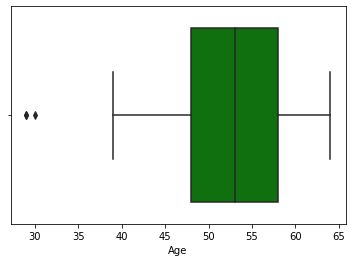

Height
min:  55
max:  207


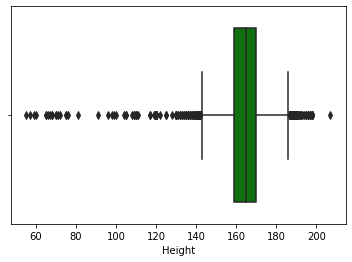

Weight
min:  10.0
max:  200.0


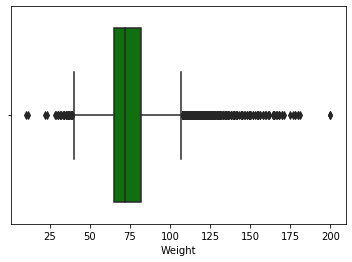

High Blood Pressure
min:  -150
max:  14020


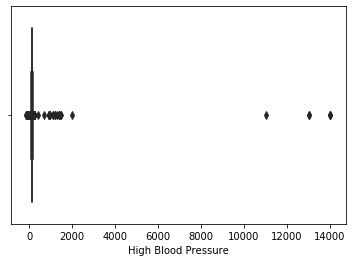

Low Blood Pressure
min:  0
max:  11000


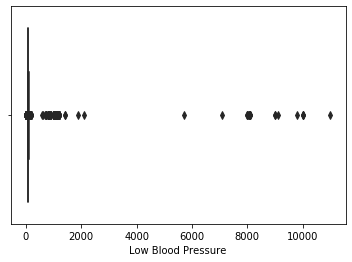

In [7]:
col_num = ['Age','Height','Weight','High Blood Pressure','Low Blood Pressure']
for col in col_num:
    if csv_data[col].dtypes == np.float64 or csv_data[col].dtypes == np.int64:
        print(col)
        print("min: ", min(csv_data[col]))
        print("max: ", max(csv_data[col]))
        sn.boxplot(x=col, data = csv_data,color = 'green')
        plt.show()

There are many things that can be iferred from the above cell output. These are:
<br>
1) The min age is 29 and max is 64, although the value for age varaible is centered aroud 40 and 65 and as there is nothing mentioned about the disease in question so we cannot rule out the possibility of a person of younger age getting the disease. It would be rare but still possible and thus, we won't replace outlies i.e. less than 35 for age variable
<br>
2) max height recorded in world is 251cm and min height recorded is 54.64cm and the max and min height recorded in the data are 55cm and 207cm thus, it is possible that these values are not actually outliers insted they show the presence of pretty short and tall people.
<br>
3) As we know the min height in dataset is 55 cm and min age is 29 it is not possible to have an individual with weight of 10kgs. The min weight for adults is usually around 40kgs and thus, we need to interpolate these values with median. Median is choosen for interpolation as mean is sensetive to outliers. Weight above 180kgs is a possibility. Max weight for an individual is recorded as 357 kgs and thus, values above 180kgs shouldn't be treated as outliers, insted these values make sure that rare cases are considered in the data while building models
<br>
4) For High Blood Pressure the min value in the data is -150 and max is 14020 which is not technically possible. Usually 180+ High Blood Pressure is considered as hypertensive crisis. Also, according to a research the highest mean BP recorded was 190/175 mg thus, it is safe to consider any High BP values above 200 as an outlier and lower than 80 as an outlier. Outliers can again be replaced with median value
<br>
5) For Low Blood Pressure the min value in the data is 0 and max is 11000 which is not technically possible.As discussed above it is safe to assume the hightest Low Blood Pressure as 175 mg and the lowest as 40. All the values outside this range should be treated as outlier and should be interpolated. 

In [8]:
median_HBP = csv_data['High Blood Pressure'].median()
median_LBP = csv_data['Low Blood Pressure'].median()
median_weight = csv_data['Weight'].median()
csv_data.loc[(csv_data['High Blood Pressure']>200),'High Blood Pressure'] = median_HBP
csv_data.loc[(csv_data['High Blood Pressure']<80),'High Blood Pressure'] = median_HBP
csv_data.loc[(csv_data['Low Blood Pressure']>175),'Low Blood Pressure'] = median_LBP
csv_data.loc[(csv_data['Low Blood Pressure']<40),'Low Blood Pressure'] = median_LBP
csv_data.loc[(csv_data['Weight']<40),'Weight'] = median_weight

After replacing the outliers in the data there are still some discrepencies that can occur such as the value of High Blood Pressure is lower than the value of Low Blood Pressure which is not really possible. Thus, it is important to remove these columns. There are 63 such coluns

In [9]:
csv_data[csv_data['High Blood Pressure']<csv_data['Low Blood Pressure']]
csv_data.drop(csv_data[csv_data['High Blood Pressure']<csv_data['Low Blood Pressure']].index, inplace = True, axis =0)

## Data Vizualizations

There are many questions that can be answered by plotting graphs and which might give us intresting insights about the data

#### How balanced is the data?

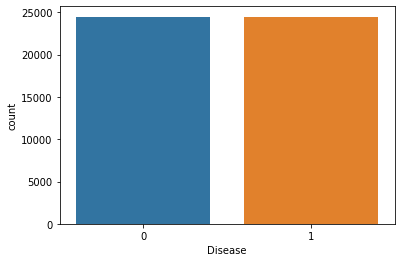

In [10]:
ax = sn.countplot(x ='Disease',data=csv_data)

The data is balanced in respect to the target variable i.e the number of people in the sample who don't suffer from a disease is almost equal to the number of people who suffer from the disease



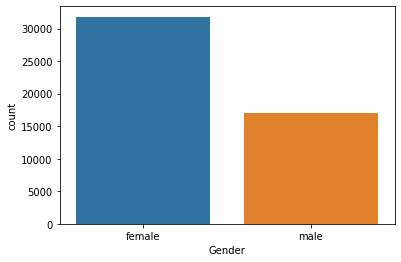

In [11]:
sn.countplot(x ='Gender',data=csv_data)

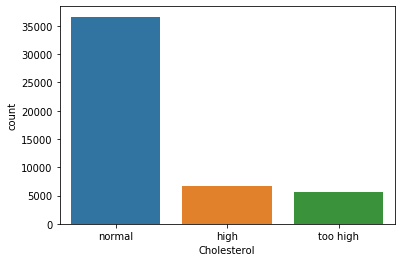

In [12]:
sn.countplot(x ='Cholesterol',data=csv_data)

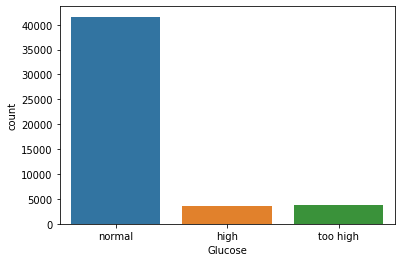

In [13]:
sn.countplot(x ='Glucose',data=csv_data)


<br>

We can observe a imbalance in data with respect to the categorical variables Glucose, Cholestrol and Gender. Especially Glusocose and Cholestrol are highly imbalanced it would be intreting to see if these values of Glucose and Cholestrol which are low in number directly impact the possibility of person suffering with disease. In other words Does high Glucose or Cholestrol garuntee that person will catch the disease? 

##### Impact of Cholesterol, Glucose and Gender on Disease

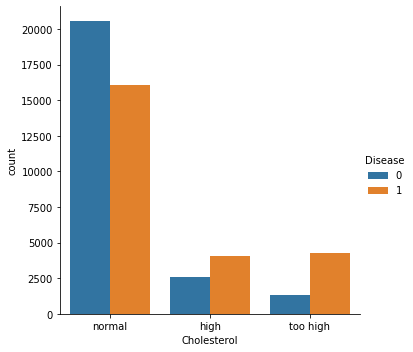

In [14]:
sn.catplot( x = "Cholesterol",kind="count",data = csv_data,hue="Disease")

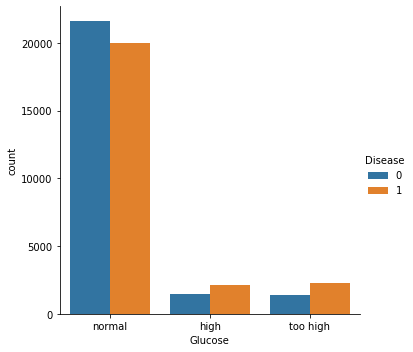

In [15]:
sn.catplot( x = "Glucose",kind="count",data = csv_data,hue="Disease")

Presence of high or too high Glucose and Cholestrol does increase the chances that a person sufferes from the disease. We can see 60% of people with high Cholestrol and 75% of people with too high Cholestrol do suffer from the disease

For Glucose, 55% people with high glucose and 65% people with too high glucose suffer from the disease

#### Impact of smoking and Alcohol Consuption on probability of person suffering with Disease. 

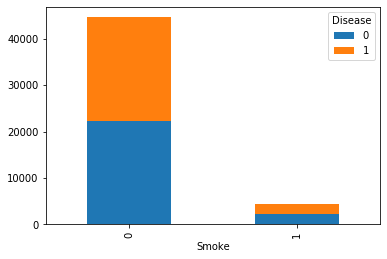

In [16]:
pd.crosstab(csv_data['Smoke'], csv_data['Disease']).plot(kind='bar', stacked=True)

Almost 91% of people present in the sample don't smoke and 50% of these people suffer with the disease in question. Similarly from the 9% people in sample smoke 55% of these people don't suffer from the disease

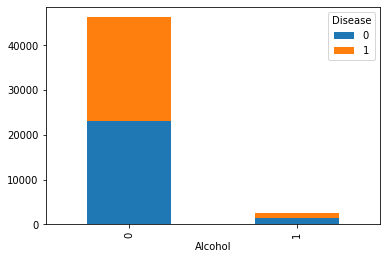

In [17]:
pd.crosstab(csv_data['Alcohol'], csv_data['Disease']).plot(kind='bar', stacked=True)

Almost 95% of people present in the sample don't drink alcohol and 50% of these people suffer with the disease in question. Similarly from the 5% people in sample drink alcohol and 50% of these people don't suffer from the disease. 

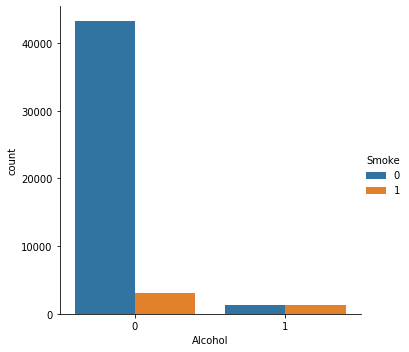

In [18]:
sn.catplot( x = "Alcohol",kind="count",data = csv_data,hue="Smoke")

From 95%(46k) of people in the sample who don't consume alcohol approximately, 10%(4.5k) of these people smoke while from 5%(3k)of people in the sample who consume alcohol approximately 50%(1.5k) of these people also smoke

#### Impact of Blood Pressure

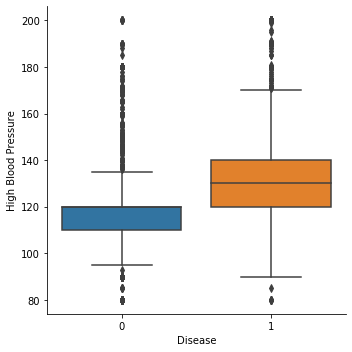

In [19]:
sn.catplot(x = "Disease", y = "High Blood Pressure",data = csv_data,kind ="box")

The plot above shows the box plot for High Blood Pressure for people suffering from disease and not suffering from disease. It is evident that people who suffer from the disease mostly have High Blood Pressure value above 120

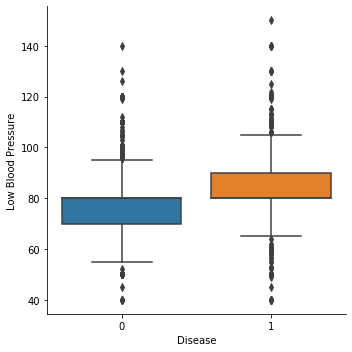

In [20]:
sn.catplot(x = "Disease", y = "Low Blood Pressure",data = csv_data,kind ="box")

The plot above shows the box plot for Low Blood Pressure for people suffering from disease and not suffering from disease. It is evident that people who suffer from the disease mostly have Low Blood Pressure value above 80

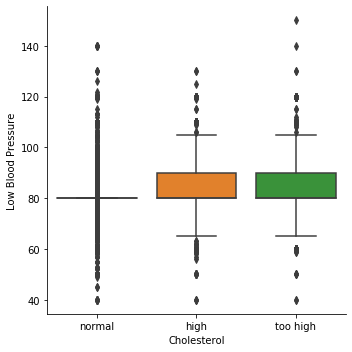

In [21]:
sn.catplot(x = "Cholesterol", y = "Low Blood Pressure",data = csv_data,kind ="box")

Usually people who have high and too high Cholestrol have Low Blood Pressure greater than 80

#### Feature transformation

##### Training and testing datasets

Split data into training and testing dataset. Stratify sampling will ensure that the ratio values in specified column remains same in training and testing data set as population data. i.e divide a population into homogeneous subpopulations called strata (the plural of stratum) based on specific characteristics in this case Disease

In [22]:
X = csv_data[csv_data.columns.difference(['Disease'])]
Y = csv_data['Disease']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state = 50)

##### Numerization of Categorical variable 

All the algorithms NBC, SVM, KNN, Ensemble Learning and Random Forest take numeric data as input thus, it is important to convert the categorical data into numeric form. While the Label Encoding i.e. converting each categorical variable into ordinal works good with tree based model the distance based model such as KNN and SVM don't perform as expected and thus, for them it is best to use One Hot Encoder i.e dummy varaibles

In [23]:
oe = OneHotEncoder(handle_unknown="ignore",sparse=False)
le = LabelEncoder()

###### Label Encoding for tree based models

In [24]:
le_data = csv_data.copy()
oh_data =  csv_data.copy()
for col in le_data.columns:
    if le_data[col].dtypes == np.object:
        print(col)
        le_data[col] = le_data[col].astype(str)
        csv_le = le.fit(le_data[col])
        le_data[col] = csv_le.transform(le_data[col])

Gender
Cholesterol
Glucose


###### One Hot Encoding for distance based models

For distance based algorithms i.e. SVM and KNN it is a common practice to scale the data as large values can cause greater distances even if the instances are close to one another. However, in case of this data there isn't much diffrence in the value of range variables thus, scaling and then dimesionality reduction might not improve the performace. To experiment with and see the impact of scaling and PCA we can create two pipelines the fiest one will just do encoding of data while 2nd would do encoding scaling and PCA

In [25]:

cat_features = ['Cholesterol', 'Gender', 'Glucose','Smoke','Alcohol','Exercise']
num_features = [x for x in X.columns if x not in cat_features]

categorical_transformer = Pipeline(steps=[("ohe",oe)])

numeric_transformer = Pipeline(steps=[("mms",MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])


oh_ss_pc = Pipeline(steps=[("preprocessor",preprocessor),("pca",PCA(n_components=10))])

Train Test data for tree based and probability based classifiers 

In [26]:
X_le = le_data[le_data.columns.difference(['Disease'])]
Y_le = le_data['Disease']
X_train_le,X_test_le,y_train_le,y_test_le = train_test_split(X_le,Y_le,test_size=0.2,stratify=Y,random_state = 50)

##### Model Evaluvation Metrics

For each model there is a confusion matrix which gives us an idea about true positive true negatives false positive and false negative values. Also, there a classification report which gives precision recall and f-1 for each class along with accuracy for the model

For model evaluvation the best metrics according to our dataset and target variable is recall(tp/(tp+fn)). The target variable is to predict if a person is suffering from a disease or not here false negative values are very dangerous i.e. if a person is actually suffering from the disease but the model predicts otherwise so recall would be a better metrics as compared to precision. False positives are bad but not as bad as flase negatives. Also, the dataset seems balanced with respect to target variable so recall would be a better metrics as compared to f1 score.

Also, there is a ROC curve and AUC score for eligible models. AUC score represents how much the model is able to seprate or distinguish between two classes while ROC curve 

### Naive Bayes Classifier

#### Gaussian Naïve Bayes

In [27]:
# model training and performance evaluvation
target_names = ['class 0', 'class 1']
gnb = GaussianNB()
gnb.fit(X_train_le, y_train_le)
gnb_pred = gnb.predict(X_test_le)
print(confusion_matrix(y_test_le, gnb_pred))
print(classification_report(y_test_le,gnb_pred,target_names=target_names))

[[3892 1004]
 [1731 3159]]
              precision    recall  f1-score   support

     class 0       0.69      0.79      0.74      4896
     class 1       0.76      0.65      0.70      4890

    accuracy                           0.72      9786
   macro avg       0.73      0.72      0.72      9786
weighted avg       0.73      0.72      0.72      9786



In [28]:
#model underfitting evaluvation
uf = gnb.predict(X_train_le)
print(confusion_matrix(y_train_le,uf))
print(classification_report(y_train_le,uf,target_names=target_names))

[[15495  4089]
 [ 7074 12482]]
              precision    recall  f1-score   support

     class 0       0.69      0.79      0.74     19584
     class 1       0.75      0.64      0.69     19556

    accuracy                           0.71     39140
   macro avg       0.72      0.71      0.71     39140
weighted avg       0.72      0.71      0.71     39140



0.7860217681141987


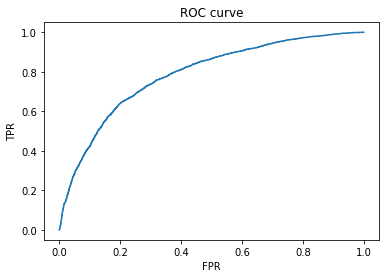

In [29]:
#AUC and ROC
predictions = gnb.predict_proba(X_test_le)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### Bernoulli Naïve Bayes

In [30]:
# model training and performance evaluvation
bnb = BernoulliNB()
bnb.fit(X_train_le, y_train_le)
bnb_pred = bnb.predict(X_test_le)
metrics.accuracy_score(y_test_le, bnb_pred)
print(confusion_matrix(y_test_le, bnb_pred))
print(classification_report(y_test_le,bnb_pred,target_names=target_names))

[[3482 1414]
 [3119 1771]]
              precision    recall  f1-score   support

     class 0       0.53      0.71      0.61      4896
     class 1       0.56      0.36      0.44      4890

    accuracy                           0.54      9786
   macro avg       0.54      0.54      0.52      9786
weighted avg       0.54      0.54      0.52      9786



In [31]:
#model underfitting evaluvation
uf = bnb.predict(X_train_le)
print(confusion_matrix(y_train_le,uf))
print(classification_report(y_train_le,uf,target_names=target_names))

[[14029  5555]
 [12369  7187]]
              precision    recall  f1-score   support

     class 0       0.53      0.72      0.61     19584
     class 1       0.56      0.37      0.45     19556

    accuracy                           0.54     39140
   macro avg       0.55      0.54      0.53     39140
weighted avg       0.55      0.54      0.53     39140



0.54432966438109


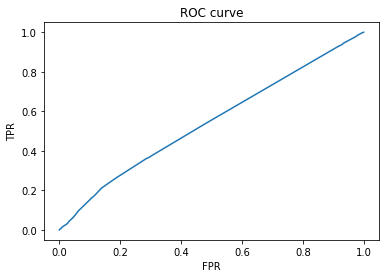

In [32]:
#AUC and  ROC
predictions = bnb.predict_proba(X_test_le)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### Multinomial Naïve Bayes

In [33]:
# model training and performance evaluvation
mnb = MultinomialNB()
mnb.fit(X_train_le, y_train_le)
mnb_pred = mnb.predict(X_test_le)
metrics.accuracy_score(y_test_le, mnb_pred)
print(confusion_matrix(y_test_le, mnb_pred))
print(classification_report(y_test_le,mnb_pred,target_names=target_names))

[[3839 1057]
 [1817 3073]]
              precision    recall  f1-score   support

     class 0       0.68      0.78      0.73      4896
     class 1       0.74      0.63      0.68      4890

    accuracy                           0.71      9786
   macro avg       0.71      0.71      0.70      9786
weighted avg       0.71      0.71      0.70      9786



In [34]:
#model underfitting evaluvation
uf = mnb.predict(X_train_le)
print(confusion_matrix(y_train_le,uf))
print(classification_report(y_train_le,uf,target_names=target_names))

[[15228  4356]
 [ 7274 12282]]
              precision    recall  f1-score   support

     class 0       0.68      0.78      0.72     19584
     class 1       0.74      0.63      0.68     19556

    accuracy                           0.70     39140
   macro avg       0.71      0.70      0.70     39140
weighted avg       0.71      0.70      0.70     39140



0.758658627050002


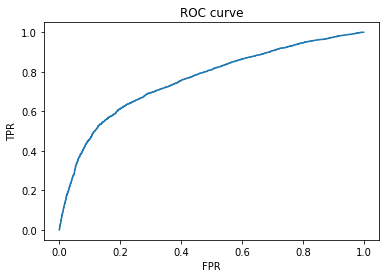

In [35]:

predictions = mnb.predict_proba(X_test_le)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

###### Performance Evaluvation
It is evident from the above results that Gaussian Naïve Bayes has both higher precision and recall for predicting people who suffer with disease and also highest model accuracy thus, Gaussian Naïve Bayes is the best model from all three.

The BernoulliNB whih AUC score of approximately 0.5 represents that the model has no class seperation capabilities and shows poor model performance. The Gausian Naïve Bayes again shows highest AUC score as predicted beacuse it has higher values of recall f-1 

###### Overfitting and Underfitting

The training data accuracy for all three models is almost similar to the tesing data accuracy. The Bernoulli Naïve Bayes model seems to be underfitting with a training accuracy of just 55%

### Ensemble Learning

In [45]:
from sklearn.ensemble import GradientBoostingClassifier as gbm

gb = gbm(random_state=16)
param_grid = {'n_estimators':[100,200,300],
             'max_depth': [2,3],
             'learning_rate': [1,0.1]}

gridgb = GridSearchCV(gb,param_grid,cv=3)
gridgb.fit(X_train_le,y_train_le)

y_pred_gb = gridgb.predict(X_test_le)
print(confusion_matrix(y_test_le, y_pred_gb))
print(classification_report(y_test_le,y_pred_gb,target_names=target_names))
el_df = pd.DataFrame(gridgb.cv_results_)

NotFittedError: This GridSearchCV instance was initialized with refit=False. predict is available only after refitting on the best parameters. You can refit an estimator manually using the ``best_params_`` attribute

In [37]:
print("Training Accuracy for best GBT: ",gridgb.best_score_)

print("Best Hyperparameters")
for hps, values in gridgb.best_params_.items():
    print(f"{hps}: {values}")

Training Accuracy for best GBT:  0.7364077669902913
Best Hyperparameters
learning_rate: 0.1
max_depth: 3
n_estimators: 200


0.8089127262186402


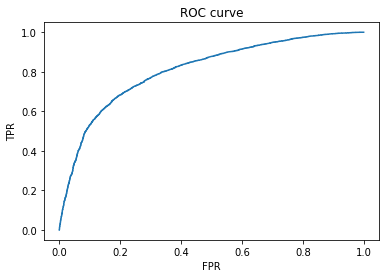

In [38]:
predictions = gridgb.predict_proba(X_test_le)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

###### Performance Evaluvation

The recall for gradient boosting tree is 0.70 for class 1 which is greater than that of Gaussian Naïve Bayes thus, we can say that the GBT model performs better as compared to Naïve Bayes both in terms of precision accuracy and Recall.

The ROC as expected is higher as compared to Gausssian Naïve Bayes and gives us a idea that tree based model performs better than probability based approach

###### Overfitting and Underfitting

The training accuracy for the best GBT is around 73.5% and the testing accuracy is also same hence, we can see the model is neither overfitting nor underfitting

###### Hyperparameter Tuning
 
The hyperparameters choosed for GBT are:

n_estimators - The number of boosting stages to perform. GBT is robust to overfitting and thus the larger this number the better

max_depth - Limits the num of nodes in the tree i.e. max depth of each estimator

learning_rate - shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
param_grid = {'n_estimators':[100,200],
             'max_features':[2,5,10],
             'criterion':['gini','entropy']}

gridrfc = GridSearchCV(rfc,param_grid,cv=3)
gridrfc.fit(X_train_le,y_train_le)

y_pred_rfc = gridrfc.predict(X_test_le)
print(confusion_matrix(y_test_le, y_pred_rfc))
print(classification_report(y_test_le,y_pred_rfc,target_names=target_names))
pd.DataFrame(gridrfc.cv_results_)

[[3507 1389]
 [1421 3469]]
              precision    recall  f1-score   support

     class 0       0.71      0.72      0.71      4896
     class 1       0.71      0.71      0.71      4890

    accuracy                           0.71      9786
   macro avg       0.71      0.71      0.71      9786
weighted avg       0.71      0.71      0.71      9786



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.667483,0.044750,0.275501,0.015465,gini,2,100,"{'criterion': 'gini', 'max_features': 2, 'n_es...",0.716103,0.711964,0.708340,0.712136,0.003172,4
1,3.382938,0.076725,0.569333,0.004626,gini,2,200,"{'criterion': 'gini', 'max_features': 2, 'n_es...",0.718403,0.713497,0.710026,0.713975,0.003436,1
2,2.701421,0.040246,0.263758,0.004938,gini,5,100,"{'criterion': 'gini', 'max_features': 5, 'n_es...",0.713037,0.712041,0.703817,0.709632,0.004132,8
3,5.717344,0.531002,0.553559,0.032962,gini,5,200,"{'criterion': 'gini', 'max_features': 5, 'n_es...",0.713037,0.713651,0.705964,0.710884,0.003488,6
4,4.421390,0.089529,0.257976,0.004854,gini,10,100,"{'criterion': 'gini', 'max_features': 10, 'n_e...",0.705296,0.708439,0.697302,0.703679,0.004688,12
5,8.896430,0.132218,0.497006,0.008212,gini,10,200,"{'criterion': 'gini', 'max_features': 10, 'n_e...",0.706753,0.706599,0.701134,0.704829,0.002613,11
6,1.850720,0.019301,0.272757,0.004716,entropy,2,100,"{'criterion': 'entropy', 'max_features': 2, 'n...",0.717483,0.713881,0.708110,0.713158,0.003861,3
7,3.686978,0.025462,0.541732,0.004154,entropy,2,200,"{'criterion': 'entropy', 'max_features': 2, 'n...",0.717406,0.712424,0.711252,0.713694,0.002668,2
8,3.136015,0.015322,0.270707,0.005538,entropy,5,100,"{'criterion': 'entropy', 'max_features': 5, 'n...",0.711888,0.713497,0.705197,0.710194,0.003594,7
9,6.077298,0.031445,0.530079,0.018478,entropy,5,200,"{'criterion': 'entropy', 'max_features': 5, 'n...",0.714647,0.712884,0.705197,0.710910,0.004103,5


In [40]:
print("Training Accuracy for best RF model: ",gridrfc.best_score_)

print("Best Hyperparameters")
for hps, values in gridrfc.best_params_.items():
    print(f"{hps}: {values}")

Training Accuracy for best RF model:  0.7140776699029127
Best Hyperparameters
criterion: gini
max_features: 2
n_estimators: 200


0.7774520872595801


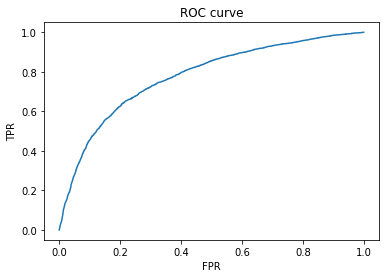

In [41]:
predictions = gridrfc.predict_proba(X_test_le)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

###### Performance Evaluvation

The recall for random forest is 0.701 for class 1 which is greater than that of GBT, however the accuracy and recall for class 0 is less as compared to GBT. But as we are considering recall for class 1 as our metrics for evaluvation we can say RF performs slightly better than GBT

The ROC is lower as compared to GBTs and gives us a idea that GBT performs better in task of class seperation

###### Overfitting and Underfitting

The training accuracy for the best RF is around 71.5% and the testing accuracy is also same hence, we can see the model is neither overfitting nor underfitting

###### Hyperparameter Tuning
 
The hyperparameters choosed for RF are:

n_estimators - The number of trees in the forest

max_depth - Max depth of each tree in forest

criterion - Entropy splits based on the information gained and gini based on gini impurity

In [42]:
feature_imp = pd.DataFrame(gridrfc.best_estimator_.feature_importances_, index=X_train_le.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp

,importance
Weight,0.228427
Height,0.206853
High Blood Pressure,0.190069
Age,0.179741
Low Blood Pressure,0.093485
Cholesterol,0.040253
Glucose,0.019562
Gender,0.014179
Exercise,0.012353
Smoke,0.007955


As we can see from above the most important feature for predicting disease is Weight, Height and Age according to the RF model

### Linear SVM (without scaling and PCA)

In [43]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features)])
X_train_oh = preprocessor1.fit_transform(X_train)
X_test_oh = preprocessor1.transform(X_test)

In [44]:
lsvm = svm.LinearSVC()

param_grid = {'C':[10,1,0.1],
              'penalty':['l2'],
              'max_iter':[500,1000,5000],
              'loss':['hinge','squared_hinge']}

gridlsvm = GridSearchCV(lsvm,param_grid,cv=3)
gridlsvm.fit(X_train_oh,y_train)

y_lsvm = gridlsvm.predict(X_test_oh)
print(confusion_matrix(y_test, y_lsvm))
print(classification_report(y_test, y_lsvm,target_names=target_names))
pd.DataFrame(gridlsvm.cv_results_)

[[3871 1025]
 [2942 1948]]
              precision    recall  f1-score   support

     class 0       0.57      0.79      0.66      4896
     class 1       0.66      0.40      0.50      4890

    accuracy                           0.59      9786
   macro avg       0.61      0.59      0.58      9786
weighted avg       0.61      0.59      0.58      9786



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_loss,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.099158,0.002947,0.001464,0.000143,10,hinge,500,l2,"{'C': 10, 'loss': 'hinge', 'max_iter': 500, 'p...",0.588794,0.594696,0.590756,0.591415,0.002454,10
1,0.097992,0.001596,0.001326,0.000016,10,hinge,1000,l2,"{'C': 10, 'loss': 'hinge', 'max_iter': 1000, '...",0.588794,0.594696,0.590756,0.591415,0.002454,10
2,0.098891,0.000727,0.001353,0.000017,10,hinge,5000,l2,"{'C': 10, 'loss': 'hinge', 'max_iter': 5000, '...",0.588794,0.594696,0.590756,0.591415,0.002454,10
3,0.508057,0.008386,0.001410,0.000016,10,squared_hinge,500,l2,"{'C': 10, 'loss': 'squared_hinge', 'max_iter':...",0.592320,0.596152,0.591829,0.593434,0.001933,9
4,0.968864,0.015202,0.001405,0.000010,10,squared_hinge,1000,l2,"{'C': 10, 'loss': 'squared_hinge', 'max_iter':...",0.592243,0.595999,0.592212,0.593485,0.001778,1
5,1.492890,0.009689,0.001426,0.000010,10,squared_hinge,5000,l2,"{'C': 10, 'loss': 'squared_hinge', 'max_iter':...",0.592243,0.595999,0.592212,0.593485,0.001778,1
6,0.023877,0.000040,0.001308,0.000020,1,hinge,500,l2,"{'C': 1, 'loss': 'hinge', 'max_iter': 500, 'pe...",0.588794,0.594696,0.590756,0.591415,0.002454,10
7,0.024019,0.000153,0.001282,0.000002,1,hinge,1000,l2,"{'C': 1, 'loss': 'hinge', 'max_iter': 1000, 'p...",0.588794,0.594696,0.590756,0.591415,0.002454,10
8,0.023920,0.000384,0.001278,0.000006,1,hinge,5000,l2,"{'C': 1, 'loss': 'hinge', 'max_iter': 5000, 'p...",0.588794,0.594696,0.590756,0.591415,0.002454,10
9,0.229715,0.056718,0.001384,0.000029,1,squared_hinge,500,l2,"{'C': 1, 'loss': 'squared_hinge', 'max_iter': ...",0.592243,0.595999,0.592212,0.593485,0.001778,1


In [45]:
print("Training Accuracy for best Linear SVM model without scaling: ",gridlsvm.best_score_)

print("Best Hyperparameters")
for hps, values in gridlsvm.best_params_.items():
    print(f"{hps}: {values}")

Training Accuracy for best Linear SVM model without scaling:  0.5934849259070005
Best Hyperparameters
C: 10
loss: squared_hinge
max_iter: 1000
penalty: l2


###### Performance Evaluvation

As discussed the training for distance based models are done without scaling and Dimnensionality reduction in the data transformation task and also with them. The Linear SVM with out scaling does a great task in predicting class 0 with high recall and its performance is very low for class 1. As it is important to have less false negatives for this task we can this model is less suitable as compared to others discussed above. Also, the acuuracy for the model is pretty low as compared to other models

###### Overfitting and Underfitting

The training accuracy is less as compared to testing accuracy this can be due to two reason the first is either the train and test data are not same which is not the case and the second is that the regularization is high which could be possible

###### Hyperparameter Tuining

C - Regularization parameter. The strength of the regularization is inversely proportional to C

max_iter - The max number of iterations to run

loss - Specifies the loss function. ‘hinge’ is the standard SVM loss while ‘squared_hinge’ is the square of the hinge loss



### Non-Linear SVM (without scaling and PCA)

In [46]:
nlsvm=svm.SVC()

param_grid = {'C':[10,1],
              'max_iter':[10000,20000],
              'kernel':['poly','rbf'],
              'degree':[2,3],
              'gamma':[1,0.1]
             }
gridnlsvm = GridSearchCV(nlsvm,param_grid,cv=3)

gridnlsvm.fit(X_train_oh,y_train)

y_nlsvm = gridnlsvm.predict(X_test_oh)
print(confusion_matrix(y_test, y_nlsvm))
print(classification_report(y_test,y_nlsvm,target_names=target_names))
pd.DataFrame(gridnlsvm.cv_results_)

[[1567 3329]
 [1383 3507]]
              precision    recall  f1-score   support

     class 0       0.53      0.32      0.40      4896
     class 1       0.51      0.72      0.60      4890

    accuracy                           0.52      9786
   macro avg       0.52      0.52      0.50      9786
weighted avg       0.52      0.52      0.50      9786



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.894541,0.308399,2.165749,0.132288,10,2,1,poly,10000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.502874,0.527478,0.512801,0.514384,0.010107,27
1,10.666113,0.108480,2.931410,0.016285,10,2,1,poly,20000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.591707,0.585958,0.586617,0.588094,0.002569,16
2,10.331367,0.996509,3.606108,0.417658,10,2,1,rbf,10000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.506093,0.449375,0.547754,0.501073,0.040319,31
3,14.966562,0.326834,5.133369,0.019052,10,2,1,rbf,20000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.592703,0.593776,0.593362,0.593281,0.000442,7
4,7.717384,0.632987,2.486754,0.297921,10,2,0.1,poly,10000,"{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel':...",0.508469,0.555990,0.508278,0.524246,0.022447,26
5,10.024160,0.440937,3.261735,0.248192,10,2,0.1,poly,20000,"{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel':...",0.591554,0.595309,0.593439,0.593434,0.001533,1
6,12.452626,1.030676,4.269192,0.227892,10,2,0.1,rbf,10000,"{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel':...",0.507933,0.593546,0.584240,0.561906,0.038354,21
7,15.892913,0.329178,5.188490,0.025542,10,2,0.1,rbf,20000,"{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel':...",0.591860,0.592550,0.593822,0.592744,0.000813,11
8,6.411961,0.342385,1.949673,0.148935,10,3,1,poly,10000,"{'C': 10, 'degree': 3, 'gamma': 1, 'kernel': '...",0.505940,0.513988,0.512571,0.510833,0.003508,28
9,10.854719,0.080101,2.919689,0.023966,10,3,1,poly,20000,"{'C': 10, 'degree': 3, 'gamma': 1, 'kernel': '...",0.584196,0.593623,0.592902,0.590240,0.004284,14


In [47]:
print("Training Accuracy for best Non - Linear SVM model without scaling: ",gridnlsvm.best_score_)

print("Best Hyperparameters")
for hps, values in gridnlsvm.best_params_.items():
    print(f"{hps}: {values}")

Training Accuracy for best Non - Linear SVM model without scaling:  0.5934338272866633
Best Hyperparameters
C: 10
degree: 2
gamma: 0.1
kernel: poly
max_iter: 20000


###### Performance Evaluvation
The Non-Linear SVM with out scaling does a great task in predicting class 1 with high recall and its performance is very low for class 0. The accuracy of model is pretty less though. The RF models gives around same reacall and better accuracy thus, RF is better as compared to this model inspite of having almost same recall

###### Overfitting and Underfitting

The training accuracy is almost same as tesing accuracy thus the model is not overfitting. Hoever less trianing accuracy is an indication of possible underfitting

###### Hyperparameter tuning

C - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

max_iter - max iterations to run

kernel - Specifies the kernel type to be used in the algorithm

degree - Degree of the polynomial kernel function (‘poly’)

gamma - Kernel coefficient

### KNN (without scaling and PCA)

In [48]:
neighbors = list(range(1, 50))
train_results = []
test_results = []
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_oh, y_train)
    train_pred = knn.predict(X_train_oh)
    acc = cross_val_score(knn, X_train_oh, y_train, cv=3).mean()*100
    train_results.append(acc)
    y_pred = knn.predict(X_test_oh)
    acc_test = round(metrics.accuracy_score(y_test, y_pred)*100, 2)
    test_results.append(acc_test)

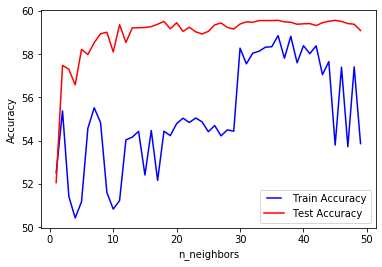

In [49]:
line1, = plt.plot(neighbors, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(neighbors, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.show()

0.6104589364716575


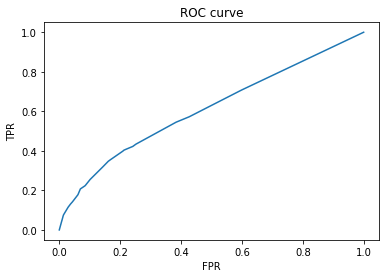

In [50]:
knn = KNeighborsClassifier(n_neighbors=45)
knn.fit(X_train_oh, y_train)
predictions = knn.predict_proba(X_test_oh)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [51]:
y_knn = knn.predict(X_test_oh)
print(confusion_matrix(y_test, y_knn))
print(classification_report(y_test,y_knn,target_names=target_names))

[[3857 1039]
 [2918 1972]]
              precision    recall  f1-score   support

     class 0       0.57      0.79      0.66      4896
     class 1       0.65      0.40      0.50      4890

    accuracy                           0.60      9786
   macro avg       0.61      0.60      0.58      9786
weighted avg       0.61      0.60      0.58      9786



###### Performance Evaluvation
The K nearest neighbours with out scaling does a great task in predicting class 0 with high recall and its performance is very low for class 1. The accuracy of model is better as compared to Non-Linear SVM and is almost par to Linear SVM but low recall for class 1 makes this model less suitable.

The AUC score of 0.61 denotes that model does an okayish task in identifying seprate classes. It is a little better than Bernoulli NB

###### Overfitting and Underfitting
The training accuracy is less as compared to testing accuracy this can be due to two reason the first is either the train and test data are not same which is not the case and the second is that the regularization is high which could be possible

###### Sensitivity Analysis
The model performace for training accuracy is pretty unpredictable just one neighbour can create a high or low spike in accuracy the testing accuracy seems to be constant after growing exponentially 

### Linear SVM (with scaling and PCA)

In [52]:
X_train_std = oh_ss_pc.fit_transform(X_train)
X_test_std = oh_ss_pc.transform(X_test)

In [53]:
lsvm = svm.LinearSVC()

param_grid = {'C':[10,1,0.1,0.001,0.0001],
              'penalty':['l2'],
              'max_iter':[1000,5000,10000],
              'loss':['hinge','squared_hinge']}

gridlsvm1 = GridSearchCV(lsvm,param_grid,cv=3)
gridlsvm1.fit(X_train_std,y_train)

y_lsvm = gridlsvm1.predict(X_test_std)
print(confusion_matrix(y_test, y_lsvm))
print(classification_report(y_test, y_lsvm,target_names=target_names))
pd.DataFrame(gridlsvm1.cv_results_)

[[3861 1035]
 [1601 3289]]
              precision    recall  f1-score   support

     class 0       0.71      0.79      0.75      4896
     class 1       0.76      0.67      0.71      4890

    accuracy                           0.73      9786
   macro avg       0.73      0.73      0.73      9786
weighted avg       0.73      0.73      0.73      9786



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_loss,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.265152,0.017831,0.001375,0.000063,10,hinge,1000,l2,"{'C': 10, 'loss': 'hinge', 'max_iter': 1000, '...",0.731892,0.732506,0.722214,0.728871,0.004714,10
1,0.260115,0.004566,0.001352,0.000108,10,hinge,5000,l2,"{'C': 10, 'loss': 'hinge', 'max_iter': 5000, '...",0.731356,0.731739,0.721984,0.728360,0.004511,11
2,0.301308,0.022559,0.001378,0.000081,10,hinge,10000,l2,"{'C': 10, 'loss': 'hinge', 'max_iter': 10000, ...",0.731433,0.731586,0.721830,0.728283,0.004563,13
3,1.571516,0.158656,0.001997,0.000988,10,squared_hinge,1000,l2,"{'C': 10, 'loss': 'squared_hinge', 'max_iter':...",0.731433,0.732276,0.723440,0.729050,0.003981,6
4,4.031691,0.436394,0.001308,0.000056,10,squared_hinge,5000,l2,"{'C': 10, 'loss': 'squared_hinge', 'max_iter':...",0.731433,0.732352,0.723440,0.729075,0.004002,4
5,3.559253,1.340218,0.001372,0.000070,10,squared_hinge,10000,l2,"{'C': 10, 'loss': 'squared_hinge', 'max_iter':...",0.731433,0.732352,0.723440,0.729075,0.004002,4
6,0.047632,0.000652,0.001323,0.000015,1,hinge,1000,l2,"{'C': 1, 'loss': 'hinge', 'max_iter': 1000, 'p...",0.731356,0.731739,0.721907,0.728334,0.004547,12
7,0.050285,0.001007,0.001312,0.000003,1,hinge,5000,l2,"{'C': 1, 'loss': 'hinge', 'max_iter': 5000, 'p...",0.731356,0.731662,0.721754,0.728258,0.004600,15
8,0.053940,0.001279,0.001322,0.000013,1,hinge,10000,l2,"{'C': 1, 'loss': 'hinge', 'max_iter': 10000, '...",0.731356,0.731662,0.721830,0.728283,0.004564,13
9,0.246853,0.004622,0.001568,0.000104,1,squared_hinge,1000,l2,"{'C': 1, 'loss': 'squared_hinge', 'max_iter': ...",0.731356,0.732429,0.723517,0.729101,0.003972,1


In [54]:
print("Training Accuracy for best Linear SVM model with scaling: ",gridlsvm1.best_score_)

print("Best Hyperparameters")
for hps, values in gridlsvm1.best_params_.items():
    print(f"{hps}: {values}")

Training Accuracy for best Linear SVM model with scaling:  0.7291006642820644
Best Hyperparameters
C: 1
loss: squared_hinge
max_iter: 1000
penalty: l2


###### Performance Evaluvation
The Linear SVM with scaling does a hugely better as compared to that without scaling. The accuracy of model is better than RF and the recall for class 0 is pretty good as compared to RF and GBT however the recall for class 1 is less as compared to RF and GBT

###### Overfitting and Underfitting 
The training accuracy is almost same as tesing accuracy thus the model is not overfitting. Training accuracy of 70+ indicates that chances of model underfitting are pretty less

###### Hyperparameter Tuining

C - Regularization parameter. The strength of the regularization is inversely proportional to C

max_iter - The max number of iterations to run

loss - Specifies the loss function. ‘hinge’ is the standard SVM loss while ‘squared_hinge’ is the square of the hinge loss

### Non-Linear SVM (with scaling and PCA)

In [55]:
nlsvm=svm.SVC()

param_grid = {'C':[10,1],
              'max_iter':[10000,20000,50000],
              'kernel':['poly','rbf'],
              'degree':[2],
              'gamma':[1,0.1,0.001]
             }
gridnlsvm1 = GridSearchCV(nlsvm,param_grid,cv=3)

gridnlsvm1.fit(X_train_std,y_train)

y_nlsvm = gridnlsvm1.predict(X_test_std)
print(confusion_matrix(y_test, y_nlsvm))
print(classification_report(y_test,y_nlsvm,target_names=target_names))
pd.DataFrame(gridnlsvm1.cv_results_)

[[3841 1055]
 [1510 3380]]
              precision    recall  f1-score   support

     class 0       0.72      0.78      0.75      4896
     class 1       0.76      0.69      0.72      4890

    accuracy                           0.74      9786
   macro avg       0.74      0.74      0.74      9786
weighted avg       0.74      0.74      0.74      9786



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.862574,0.382198,1.893060,0.004318,10,2,1,poly,10000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.478654,0.483176,0.490725,0.484185,0.004979,36
1,10.766571,0.343918,2.407165,0.085632,10,2,1,poly,20000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.527708,0.519430,0.505136,0.517425,0.009323,26
2,18.149550,1.083606,2.388776,0.119065,10,2,1,poly,50000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.625201,0.636008,0.636747,0.632652,0.005277,18
3,11.713450,0.020160,3.295011,0.073368,10,2,1,rbf,10000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.730283,0.734652,0.722137,0.729024,0.005186,8
4,14.423574,0.615780,3.307544,0.216411,10,2,1,rbf,20000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.731969,0.735801,0.722674,0.730148,0.005512,5
5,15.046906,0.776072,3.366732,0.167029,10,2,1,rbf,50000,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.732122,0.734498,0.722674,0.729765,0.005107,6
6,8.788347,0.267533,2.398364,0.029645,10,2,0.1,poly,10000,"{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel':...",0.490151,0.471373,0.499387,0.486970,0.011656,35
7,12.424556,0.864068,2.452646,0.080403,10,2,0.1,poly,20000,"{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel':...",0.600828,0.615850,0.601870,0.606183,0.006849,21
8,14.238758,0.505969,2.411170,0.083472,10,2,0.1,poly,50000,"{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel':...",0.600061,0.607573,0.601640,0.603091,0.003234,22
9,11.316550,0.592885,3.165198,0.093820,10,2,0.1,rbf,10000,"{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel':...",0.732659,0.732889,0.723057,0.729535,0.004582,7


In [56]:
print("Training Accuracy for best Non Linear SVM model with scaling: ",gridnlsvm1.best_score_)

print("Best Hyperparameters")
for hps, values in gridnlsvm1.best_params_.items():
    print(f"{hps}: {values}")

Training Accuracy for best Non Linear SVM model with scaling:  0.7316300459887582
Best Hyperparameters
C: 10
degree: 2
gamma: 0.1
kernel: rbf
max_iter: 20000


###### Performance Evaluvation
The Non-Linear SVM with  scaling does a great task in predicting class 0 with high recall and its performance is also good for class 1. The accuracy of model improves greatly as compared to the one without scailing. The RF models gives less accuracy but higher recall for class 1 and thus is better

###### Performance Evaluvation
The training accuracy is almost same as tesing accuracy thus the model is not overfitting. Training accuracy of 70+ indicates that chances of model underfitting are pretty less


###### Performance Evaluvation

C - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

max_iter - max iterations to run

kernel - Specifies the kernel type to be used in the algorithm

degree - Degree of the polynomial kernel function (‘poly’)

gamma - Kernel coefficie

### KNN (with scaling and PCA)

In [57]:
neighbors = list(range(1, 50))
train_results = []
test_results = []
for n in neighbors:
    knn1 = KNeighborsClassifier(n_neighbors=n)
    knn1.fit(X_train_std, y_train)
    train_pred = knn1.predict(X_train_std)
    acc = cross_val_score(knn1, X_train_std, y_train, cv=3).mean()*100
    train_results.append(acc)
    y_pred = knn1.predict(X_test_std)
    acc_test = round(metrics.accuracy_score(y_test, y_pred)*100, 2)
    test_results.append(acc_test)

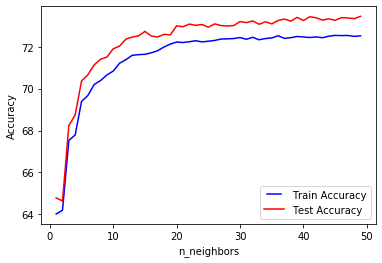

In [58]:
line1, = plt.plot(neighbors, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(neighbors, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.show()

0.7987184981354506


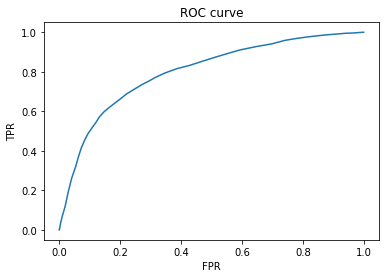

In [59]:
knn1 = KNeighborsClassifier(n_neighbors=43)
knn1.fit(X_train_std, y_train)
predictions = knn1.predict_proba(X_test_std)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [60]:
y_knn = knn1.predict(X_test_std)
print(confusion_matrix(y_test, y_knn))
print(classification_report(y_test,y_knn,target_names=target_names))

[[3700 1196]
 [1419 3471]]
              precision    recall  f1-score   support

     class 0       0.72      0.76      0.74      4896
     class 1       0.74      0.71      0.73      4890

    accuracy                           0.73      9786
   macro avg       0.73      0.73      0.73      9786
weighted avg       0.73      0.73      0.73      9786



###### Performance Evaluvation
The Knn with  scaling does a great task in predicting class 0 with high recall and its performance also good for class 1. The accuracy is better than RF model and almost equal to GBT model however the recall is better than GBT and equal to RF which makes this model the best choice for this task

###### Overfitting and Underfitting
The training accuracy is almost same as compared to testing accuracy and the model is not overfitting. Training accuracy of 70+ indicates that chances of model underfitting are pretty less

###### Sensitivity Analysis
The accuracies increase exponentialy untill 30 neighbours and then seem to increase linearly with a very less rate

### Prediction Results

In [61]:
test_data = pd.read_csv('Disease Prediction Testing.csv')

In [62]:
test_data.loc[(test_data['High Blood Pressure']>200),'High Blood Pressure'] = median_HBP
test_data.loc[(test_data['High Blood Pressure']<80),'High Blood Pressure'] = median_HBP
test_data.loc[(test_data['Low Blood Pressure']>175),'Low Blood Pressure'] = median_LBP
test_data.loc[(test_data['Low Blood Pressure']<40),'Low Blood Pressure'] = median_LBP
test_data.loc[(test_data['Weight']<40),'Weight'] = median_weight

In [63]:
le_test = test_data.copy()
oh_test =  test_data.copy()
le_test.drop(['ID'],axis =1,inplace = True)
oh_test.drop(['ID'],axis =1, inplace = True)
for col in le_test.columns:
    if le_test[col].dtypes == np.object:
        print(col)
        le_test[col] = le_test[col].astype(str)
        csv_le1 = le.fit(csv_data[col])
        le_test[col] = csv_le1.transform(le_test[col])

Gender
Cholesterol
Glucose


In [64]:
oh_test = oh_ss_pc.transform(oh_test)

In [65]:
nbc_predict = gnb.predict(le_test)
el_predict = gridgb.predict(le_test)
rfc_predict = gridrfc.predict(le_test)
lsvm_predict = gridlsvm1.predict(oh_test)
nlsvm_predict = gridnlsvm1.predict(oh_test)
knn_predict = knn1.predict(oh_test)

In [66]:
predict_dict = {'ID':test_data['ID'],'NBC':nbc_predict,'KNN':knn_predict,'LinearSVM':lsvm_predict,'SVM RBF':nlsvm_predict,'RF':rfc_predict,'GB':el_predict}

In [67]:
pd.DataFrame(predict_dict).to_csv("prediction.csv",index = False)

NameError: name 'oh_data' is not defined